In [31]:
library(tidyverse,quietly = T)
library(caret,quietly = T)
library(AppliedPredictiveModeling,quietly = T)
library(Rtsne,quietly = T)
library(dplyr,quietly = T)
.libPaths("/root/R/x86_64-conda_cos6-linux-gnu-library/3.5")
library(cluster,quietly = T)
library(fpc,quietly = T)
library(caret,quietly = T)
require(randomForest,quietly = T)
library(ROCR,quietly = T)
library(reshape,quietly = T)
library(ggpubr,quietly = T)
library(gridExtra,quietly = T)

In [2]:
#head(cancer_cases)
mccs_ess <- read.csv("/data/gunaseka/ESS_MCCS_Analysis/ess_mccs_data.csv",stringsAsFactors=FALSE)
ess_siv_probs <- read.csv("/data/gunaseka/ESS_MCCS_Analysis/ESS_SIV_Probes.csv")
dim(ess_siv_probs)

[1] 2210   31

# Remove VTRNA2-1 and DUSP22 probes

In [3]:
ess_siv_probs <- ess_siv_probs[!(ess_siv_probs$Assoc..Gene=="DUSP22" | ess_siv_probs$Assoc..Gene=="VTRNA2-1") ,]
dim(ess_siv_probs)

[1] 2189   31

[1]  863 2189

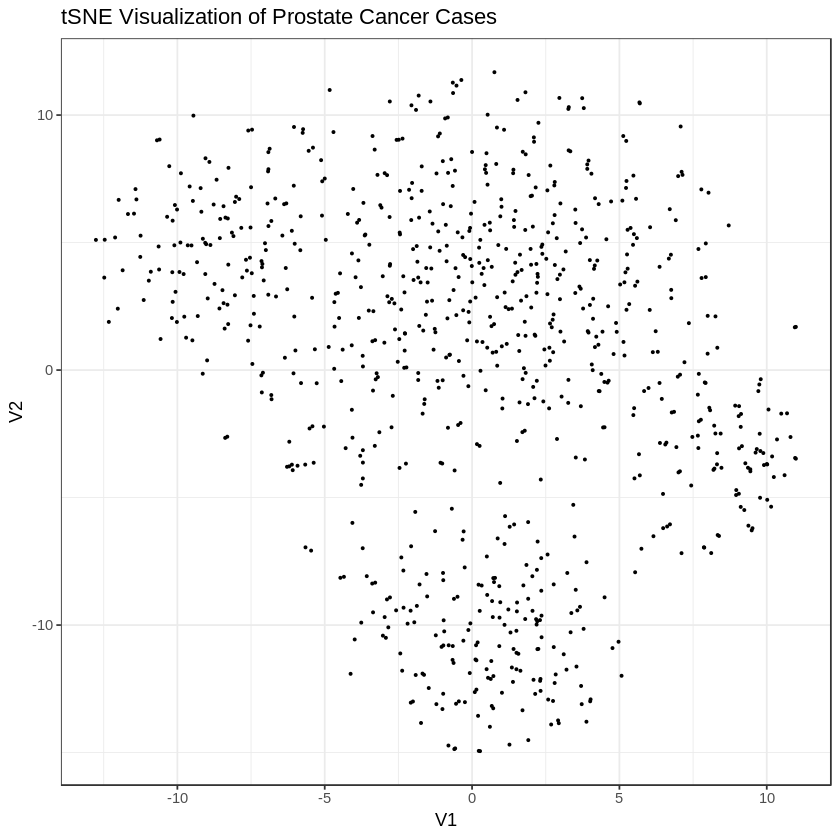

In [4]:
cancer_cases <- mccs_ess[mccs_ess$CancerCellType=='PC' & mccs_ess$CaseControl==1,]
cancer_control <- mccs_ess[mccs_ess$CancerCellType=="PC" & mccs_ess$CaseControl==0,]
cancer_cases_methy<- cancer_cases[,ess_siv_probs$CG]

dim(cancer_cases_methy)
nums <- unlist(lapply(cancer_cases_methy, is.numeric))
cancer_cases_methy <- cancer_cases_methy[,nums]
cancer_cases_methy <- cancer_cases_methy[ , colSums(is.na(cancer_cases_methy)) == 0]

set.seed(9)
tsne_model_3 = Rtsne(as.matrix(cancer_cases_methy), check_duplicates=T, pca=T, perplexity=30, theta=0.5, dims=2)
d_tsne_3 = as.data.frame(tsne_model_3$Y)

ggplot(d_tsne_3, aes(x=V1, y=V2)) +
  geom_point(size=0.45) +
  guides(colour=guide_legend(override.aes=list(size=6))) +
  xlab("V1") + ylab("V2") +theme_bw()+
  ggtitle("tSNE Visualization of Prostate Cancer Cases") +
  scale_colour_brewer(palette = "Set2")

DBSCAN clustering for 863 objects.
Parameters: eps = 1.4, minPts = 15
The clustering contains 4 cluster(s) and 177 noise points.

  0   1   2   3   4 
177 348 108 152  78 

Available fields: cluster, eps, minPts

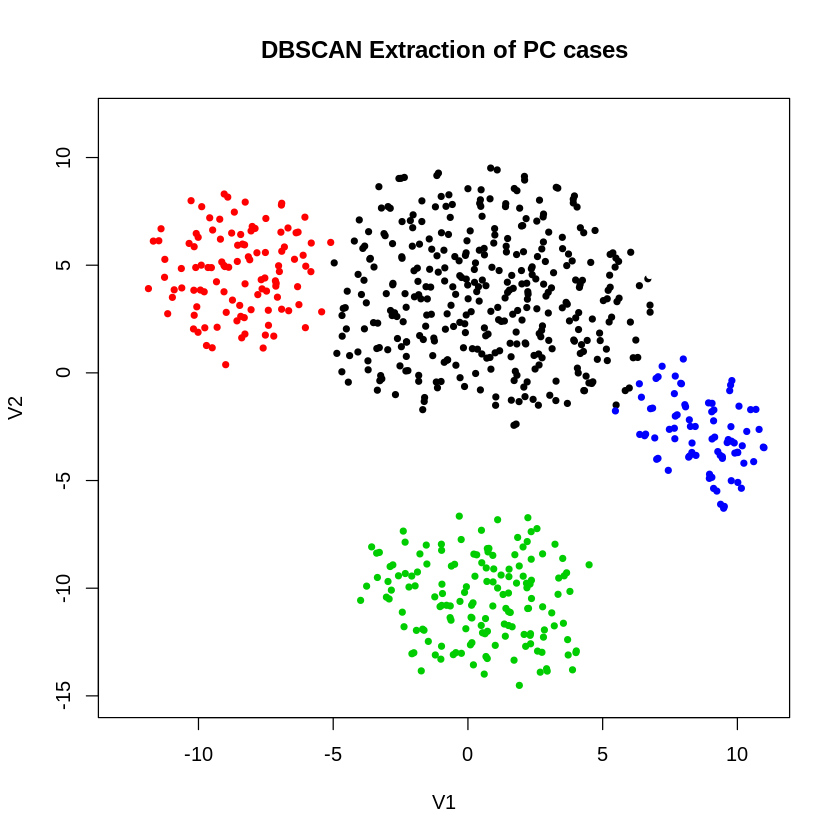

In [5]:
res <- dbscan::dbscan(d_tsne_3,eps = 1.4, minPts = 15)
plot(d_tsne_3, col=res$cluster, pch = 20,main="DBSCAN Extraction of PC cases")
#points(d_tsne_1[res$cluster == 0L], col = "grey", pch = "+")
res

In [6]:
d_tsne_3$cluster <- res$cluster
d_tsne_3$ID <- cancer_cases$ID
head(d_tsne_3) 

V1,V2,cluster,ID
7.0578659,-0.1809781,4,PC_Pair_1
1.2691464,-14.6889133,0,PC_Pair_2
5.1002495,6.6445371,0,PC_Pair_3
-2.6150420,1.5941148,1,PC_Pair_4
-1.1306926,-0.6931738,1,PC_Pair_5
0.6683236,4.0480095,1,PC_Pair_6


In [7]:
tsne_model_cluster1 <- d_tsne_3[d_tsne_3$cluster==1,]
tsne_model_cluster2 <- d_tsne_3[d_tsne_3$cluster==2,]
tsne_model_cluster3 <- d_tsne_3[d_tsne_3$cluster==3,]

# Load the data averaged by SIV_ESS cluster

In [8]:
cancer_cases_controls_avg <- read.csv("/data/gunaseka/ESS_MCCS_Analysis/averaged_accros_cluster.csv")

In [9]:
cancer_cases_controls_avg$VTRNA2.1 <- NULL
cancer_cases_controls_avg$DUSP22 <- NULL

In [10]:

cancer_cases_avg <- cancer_cases_controls_avg[cancer_cases_controls_avg$CancerCellType=="PC" & cancer_cases_controls_avg$CaseControl==1,]
cancer_controls_avg <- cancer_cases_controls_avg[cancer_cases_controls_avg$CancerCellType=="PC" & cancer_cases_controls_avg$CaseControl==0,]

In [11]:
cluster1_cases <- cancer_cases_avg[cancer_cases_avg$ID %in% tsne_model_cluster1$ID, ]
cluster2_cases <- cancer_cases_avg[cancer_cases_avg$ID %in% tsne_model_cluster2$ID, ]
cluster3_cases <- cancer_cases_avg[cancer_cases_avg$ID %in% tsne_model_cluster3$ID, ]

cluster1_controls <- cancer_controls_avg[cancer_controls_avg$ID %in% tsne_model_cluster1$ID,]
cluster2_controls <- cancer_controls_avg[cancer_controls_avg$ID %in% tsne_model_cluster2$ID,]
cluster3_controls <- cancer_controls_avg[cancer_controls_avg$ID %in% tsne_model_cluster3$ID,]

## Cases in Cluster 1  and matching controls

In [12]:
head(cluster2_cases)
head(cluster2_controls)

,Sample,CancerCellType,CaseControl,ID,AlcoholAmount,Smoking,bcell,bmi_rrto,cd4t,cd8t,⋯,USP6,VIPR2,WDR27,WDR90,ZFP57,ZFYVE28,ZNF251,ZNF681,ZNF714,ZNF890P
4361,Sample_4361,PC,1,PC_Pair_7,2,Never,0.07442135,26.34929,0.25579694,0.026708432,⋯,-1.0976488,2.392403,0.58396791,0.18407484,1.217961,3.470371,1.4334703,-1.470370,0.5409648,0.58740973
4392,Sample_4392,PC,1,PC_Pair_22,2,Never,0.10077012,29.28390,0.13257809,0.132304280,⋯,-1.1967911,1.407740,0.06604247,0.16837925,2.001196,2.518925,1.7340910,-2.416913,-1.3960639,0.59765323
4395,Sample_4395,PC,1,PC_Pair_24,2,Former,0.04931799,26.77413,0.09911398,0.044688594,⋯,-1.6729433,1.035410,2.96194432,-0.89155314,1.613340,2.769984,1.9470409,-3.424932,1.3924061,-1.87227561
4410,Sample_4410,PC,1,PC_Pair_31,1,Never,0.04546268,27.75288,0.14714214,0.111802010,⋯,-1.7188670,3.479969,0.93159380,-1.93898566,3.416423,3.451447,2.0724125,-3.941664,0.7829185,-0.06453024
4420,Sample_4420,PC,1,PC_Pair_36,2,Never,0.06187619,24.07960,0.16923040,0.008356252,⋯,-0.8106527,2.835072,0.96142906,0.08175940,3.393401,3.016254,0.3763896,-3.892923,0.7495572,1.11366734
4464,Sample_4464,PC,1,PC_Pair_58,2,Former,0.06885785,29.41172,0.13565926,0.106452960,⋯,-0.5232490,2.975224,0.91980237,-0.04944123,3.191969,2.974531,1.0828875,-1.386130,-3.0760961,0.42920154


,Sample,CancerCellType,CaseControl,ID,AlcoholAmount,Smoking,bcell,bmi_rrto,cd4t,cd8t,⋯,USP6,VIPR2,WDR27,WDR90,ZFP57,ZFYVE28,ZNF251,ZNF681,ZNF714,ZNF890P
4362,Sample_4362,PC,0,PC_Pair_7,2,Former,0.06647874,27.14332,0.1935325,0.03722157,⋯,-1.6873680,1.741208,0.7989427,-2.04126580,3.3198784,3.071718,1.9422610,-4.0265373,0.37940814,0.34790755
4391,Sample_4391,PC,0,PC_Pair_22,2,Never,0.09329004,26.19285,0.1819841,0.09261563,⋯,-1.9195860,2.530742,0.7314205,-0.08205399,-0.8321384,3.008181,1.4751140,-3.2044117,0.09639632,0.06560314
4396,Sample_4396,PC,0,PC_Pair_24,2,Former,0.06186497,29.93827,0.2277918,0.15048419,⋯,-1.6344466,1.629515,0.8908376,0.77251342,1.1638031,3.148980,1.7196554,-3.8849065,-2.95527004,-1.10076869
4409,Sample_4409,PC,0,PC_Pair_31,2,Never,0.06134267,19.84181,0.1232459,0.12494195,⋯,-0.8236424,2.869607,3.0191218,-0.12308727,1.9701354,3.130162,1.8183160,-2.9663189,-2.72774248,-0.04693596
4419,Sample_4419,PC,0,PC_Pair_36,1,Never,0.07131264,23.60571,0.1016468,0.06102648,⋯,-1.4304710,2.686792,1.2451074,0.85785375,3.4004852,3.164760,0.5058716,-3.3740972,-0.16357946,0.44919948
4463,Sample_4463,PC,0,PC_Pair_58,2,Former,0.01755306,26.64595,0.1020597,0.06936865,⋯,-0.4703608,1.579513,0.6922084,-1.32832682,3.0670194,2.791755,0.5659918,-0.8258557,-2.66794847,1.10560485


In [13]:
cluster1_data <- rbind(cluster1_cases,cluster1_controls)
cluster1_data <- subset(cluster1_data,select = -c(Sample,ID,CancerCellType,AlcoholAmount,Smoking,bcell,bmi_rrto,cd4t,cd8t,gran,mono,nk))
cluster1_data$CaseControl <- as.factor(cluster1_data$CaseControl)


cluster2_data <- rbind(cluster2_cases,cluster2_controls)
cluster2_data <- subset(cluster2_data,select = -c(Sample,ID,CancerCellType,AlcoholAmount,Smoking,bcell,bmi_rrto,cd4t,cd8t,gran,mono,nk))
cluster2_data$CaseControl <- as.factor(cluster2_data$CaseControl)


cluster3_data <- rbind(cluster3_cases,cluster3_controls)
cluster3_data <- subset(cluster3_data,select = -c(Sample,ID,CancerCellType,AlcoholAmount,Smoking,bcell,bmi_rrto,cd4t,cd8t,gran,mono,nk))
cluster3_data$CaseControl <- as.factor(cluster3_data$CaseControl)

cluster1_data$cluster <- rep("C1",dim(cluster1_data)[1])
cluster2_data$cluster <- rep("C2",dim(cluster2_data)[1])
cluster3_data$cluster <- rep("C3",dim(cluster3_data)[1])

In [14]:
all_cluster_data <- rbind(cluster1_data,cluster2_data,cluster3_data)


# Machine Learning algorithms for Classiciation

# 1. Feature Selection using Partial Lease Squares (PLS)  Algorithm 

In [15]:
for (cluster_id in c("C1","C2","C3")){
    print(paste0("Running PLS  Feature selection algorithm for ",cluster_id))
    df <- all_cluster_data[all_cluster_data$cluster==cluster_id,]
    df$CaseControl <- as.factor(df$CaseContro)
    df$cluster <- NULL
    myfolds <- createMultiFolds(df$CaseControl, k = 5, times = 10)
    control <- trainControl("repeatedcv", index = myfolds, selectionFunction = "oneSE")

    # Train PLS model
    mod1 <- train(CaseControl ~ ., data = df,
     method = "pls",
     metric = "Accuracy",
     tuneLength = 20,
     trControl = control,
     preProc = c("zv","center","scale"))
    # Check CV profile
    plot(mod1)
    print(varImp(mod1))

}

[1] "Running PLS  Feature selection algorithm for C1"



Attaching package: ‘pls’

The following object is masked from ‘package:caret’:

    R2

The following object is masked from ‘package:stats’:

    loadings



pls variable importance

  only 20 most important variables shown (out of 143)

              Overall
C7orf49        100.00
EXOC1           85.42
GSDMD           84.55
C4B.C4B_2       79.10
DOC2GP          75.03
WDR27           73.82
CYP4V2          72.63
C17orf98        70.74
LOC100128885    67.11
PLEC            65.91
PIWIL1_clus1    64.95
C6orf10         64.01
LOC641746       63.77
MIR6763         62.68
SPATC1L_clus1   61.88
SDHAP3          60.86
CCDC144NL       60.04
LOC100506159    59.85
IZUMO2          55.91
LINC01044       55.78
[1] "Running PLS  Feature selection algorithm for C2"
pls variable importance

  only 20 most important variables shown (out of 143)

                  Overall
LCLAT1             100.00
RIMS4               87.67
C4B.C4B_2           80.10
PKP3                70.33
HCG4B               69.84
LOC440910           66.79
PARD6G              66.77
PARD6G.PARD6G.AS1   66.77
TEKT4               64.63
PSORS1C3            64.61
ATP11A              64.46
CYP2E1_clus2

# Cluster 1 vs Rest

In [16]:
cluster1_cases$cluster <- rep("C1",dim(cluster1_cases)[1])
cluster2_cases$cluster <- rep("C2_3",dim(cluster2_cases)[1])
cluster3_cases$cluster <- rep("C2_3",dim(cluster3_cases)[1])

cluster1_vsRest <- rbind(cluster1_cases,cluster2_cases,cluster3_cases)
cluster1_vsRest <- subset(cluster1_vsRest,select = -c(Sample,ID,CaseControl,CancerCellType,AlcoholAmount,Smoking,bcell,bmi_rrto,cd4t,cd8t,gran,mono,nk))
cluster1_vsRest$cluster <- as.factor(cluster1_vsRest$cluster)
myfolds <- createMultiFolds(cluster1_vsRest$cluster, k = 5, times = 10)
control <- trainControl("repeatedcv", index = myfolds, selectionFunction = "oneSE")
# Train PLS model
mod1 <- train(cluster ~ ., data = cluster1_vsRest,
 method = "pls",
 metric = "Accuracy",
 tuneLength = 20,
 trControl = control,
 preProc = c("zv","center","scale"))
# Check CV profile
#plot(mod1)
print(varImp(mod1))

pls variable importance

  only 20 most important variables shown (out of 143)

             Overall
CYP2E1_clus2  100.00
CYP2E1_clus1   91.10
LOC440910      80.72
ERICH1         67.44
SDHAP3         66.98
GSTM5          64.63
LINC01169      58.14
MOBP           56.96
PDE9A          52.72
ZFYVE28        52.10
TEKT4          51.58
RIMS4          47.98
FGF12          46.74
TM9SF2         46.20
PIWIL1_clus1   46.13
C4B.C4B_2      45.09
LINC00588      44.01
LOC100128885   43.96
KIF26A         43.38
PRSS41         41.79


# Cluster 2 vs Rest

In [17]:
cluster1_cases$cluster <- rep("C1_3",dim(cluster1_cases)[1])
cluster2_cases$cluster <- rep("C2",dim(cluster2_cases)[1])
cluster3_cases$cluster <- rep("C1_3",dim(cluster3_cases)[1])

cluster1_vsRest <- rbind(cluster1_cases,cluster2_cases,cluster3_cases)
cluster1_vsRest <- subset(cluster1_vsRest,select = -c(Sample,ID,CaseControl,CancerCellType,AlcoholAmount,Smoking,bcell,bmi_rrto,cd4t,cd8t,gran,mono,nk))
cluster1_vsRest$cluster <- as.factor(cluster1_vsRest$cluster)
myfolds <- createMultiFolds(cluster1_vsRest$cluster, k = 5, times = 10)
control <- trainControl("repeatedcv", index = myfolds, selectionFunction = "oneSE")
# Train PLS model
mod1 <- train(cluster ~ ., data = cluster1_vsRest,
 method = "pls",
 metric = "Accuracy",
 tuneLength = 20,
 trControl = control,
 preProc = c("zv","center","scale"))
# Check CV profile
#plot(mod1)
print(varImp(mod1))



Warning message in fitFunc(X, Y, ncomp, Y.add = Y.add, center = center, ...):
“No convergence in 100 iterations
”

pls variable importance

  only 20 most important variables shown (out of 143)

             Overall
PF4           100.00
PM20D1         95.02
RIMS4          85.35
ACADM          79.61
C4B.C4B_2      76.36
NOX5           71.65
CYP2E1_clus2   71.29
USP6           66.56
ERICH1         65.56
CCKBR          64.31
PRSS41         64.18
PAX8.AS1       60.42
KIAA1875       59.13
MIR6763        58.99
PKP3           57.40
LCLAT1         56.86
ANKRD20A11P    56.69
LOC440910      55.38
CLDN3          55.23
UHMK1          54.92


# Cluster 3 vs Rest

In [18]:
cluster1_cases$cluster <- rep("C1_2",dim(cluster1_cases)[1])
cluster2_cases$cluster <- rep("C1_2",dim(cluster2_cases)[1])
cluster3_cases$cluster <- rep("C3",dim(cluster3_cases)[1])

cluster1_vsRest <- rbind(cluster1_cases,cluster2_cases,cluster3_cases)
cluster1_vsRest <- subset(cluster1_vsRest,select = -c(Sample,ID,CaseControl,CancerCellType,AlcoholAmount,Smoking,bcell,bmi_rrto,cd4t,cd8t,gran,mono,nk))
cluster1_vsRest$cluster <- as.factor(cluster1_vsRest$cluster)
myfolds <- createMultiFolds(cluster1_vsRest$cluster, k = 5, times = 10)
control <- trainControl("repeatedcv", index = myfolds, selectionFunction = "oneSE")
# Train PLS model
mod1 <- train(cluster ~ ., data = cluster1_vsRest,
 method = "pls",
 metric = "Accuracy",
 tuneLength = 20,
 trControl = control,
 preProc = c("zv","center","scale"))
# Check CV profile
#plot(mod1)
print(varImp(mod1))


pls variable importance

  only 20 most important variables shown (out of 143)

                  Overall
CYP2E1_clus1       100.00
CCKBR               98.57
CYP2E1_clus2        85.66
PIWIL1_clus1        85.42
PARD6G              83.41
PARD6G.PARD6G.AS1   83.41
MOBP                82.93
LINC01169           78.88
PDE9A               75.02
ZNF890P             73.01
LOC440910           70.88
ZFYVE28             69.36
ANKDD1B             68.66
PRSS50              64.11
TCEB3B              62.50
TM9SF2              60.02
SDHAP3              58.86
LOC652276           57.49
LINC00588           57.02
C17orf98            53.57


# ROC for case control classification within each cluster when VTRNA and DUSP22 is removed from analysis.

In [19]:
aucs <-c()
for(iter in 1:10){
cluster1_data$cluster <-NULL
smp_size <- floor(0.75 * nrow(cluster1_data))
train_ind <- sample(seq_len(nrow(cluster1_data)), size = smp_size)
train <- cluster1_data[train_ind, ]
test <- cluster1_data[-train_ind, ]
rf_model=randomForest(as.factor(CaseControl) ~.,data = train,ntree=200,mtry=2,importance=TRUE)
#rf_model
prediction <- predict(rf_model,subset(test,select = -c(CaseControl)))
table(observed = test$CaseControl,predicted=prediction)
# Calculate the probability of new observations belonging to each class
# prediction_for_roc_curve will be a matrix with dimensions data_set_size x number_of_classes
prediction_for_roc_curve <- predict(rf_model,subset(test,select = -c(CaseControl)),type="prob")
# Use pretty colours:
pretty_colours <- c("#F8766D")
# Specify the different classes 
classes <- levels(as.factor(test$CaseControl))
# For each class
i = 1
 # Define which observations belong to class[i]
true_values <- ifelse(test$CaseControl==classes[i],2,1)
pred <- prediction(prediction_for_roc_curve[,i],true_values)

perf <- performance(pred, "tpr", "fpr")
options(repr.plot.width=4, repr.plot.height=4)
#plot(perf,main="ROC Curve",col="#F8766D") 
auc.perf <- performance(pred, measure = "auc")
#print(auc.perf@y.values)
    aucs <-c(aucs,auc.perf@y.values)
    }
summary(unlist(aucs))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.4492  0.4866  0.5078  0.5120  0.5264  0.5789 

In [20]:
aucs <-c()
for(iter in 1:10){
cluster2_data$cluster <-NULL
smp_size <- floor(0.75 * nrow(cluster2_data))
train_ind <- sample(seq_len(nrow(cluster2_data)), size = smp_size)
train <- cluster2_data[train_ind, ]
test <- cluster2_data[-train_ind, ]
rf_model=randomForest(as.factor(CaseControl) ~.,data = train,ntree=200,mtry=2,importance=TRUE)
#rf_model
prediction <- predict(rf_model,subset(test,select = -c(CaseControl)))
table(observed = test$CaseControl,predicted=prediction)
# Calculate the probability of new observations belonging to each class
# prediction_for_roc_curve will be a matrix with dimensions data_set_size x number_of_classes
prediction_for_roc_curve <- predict(rf_model,subset(test,select = -c(CaseControl)),type="prob")
# Use pretty colours:
pretty_colours <- c("#F8766D")
# Specify the different classes 
classes <- levels(as.factor(test$CaseControl))
# For each class
i = 1
 # Define which observations belong to class[i]
true_values <- ifelse(test$CaseControl==classes[i],2,1)
pred <- prediction(prediction_for_roc_curve[,i],true_values)

perf <- performance(pred, "tpr", "fpr")
options(repr.plot.width=4, repr.plot.height=4)
#plot(perf,main="ROC Curve",col="#F8766D") 
auc.perf <- performance(pred, measure = "auc")
#print(auc.perf@y.values)
    aucs <-c(aucs,auc.perf@y.values)
    }
summary(unlist(aucs))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.3626  0.4588  0.5368  0.5134  0.5894  0.6083 

In [21]:
aucs <-c()
for(iter in 1:10){
cluster3_data$cluster <-NULL
smp_size <- floor(0.75 * nrow(cluster3_data))
train_ind <- sample(seq_len(nrow(cluster3_data)), size = smp_size)
train <- cluster3_data[train_ind, ]
test <- cluster3_data[-train_ind, ]
rf_model=randomForest(as.factor(CaseControl) ~.,data = train,ntree=200,mtry=2,importance=TRUE)
#rf_model
prediction <- predict(rf_model,subset(test,select = -c(CaseControl)))
table(observed = test$CaseControl,predicted=prediction)
# Calculate the probability of new observations belonging to each class
# prediction_for_roc_curve will be a matrix with dimensions data_set_size x number_of_classes
prediction_for_roc_curve <- predict(rf_model,subset(test,select = -c(CaseControl)),type="prob")
# Use pretty colours:
pretty_colours <- c("#F8766D")
# Specify the different classes 
classes <- levels(as.factor(test$CaseControl))
# For each class
i = 1
 # Define which observations belong to class[i]
true_values <- ifelse(test$CaseControl==classes[i],2,1)
pred <- prediction(prediction_for_roc_curve[,i],true_values)

perf <- performance(pred, "tpr", "fpr")
options(repr.plot.width=4, repr.plot.height=4)
#plot(perf,main="ROC Curve",col="#F8766D") 
auc.perf <- performance(pred, measure = "auc")
#print(auc.perf@y.values)
    aucs <-c(aucs,auc.perf@y.values)
    }
summary(unlist(aucs))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.4612  0.5261  0.5610  0.5684  0.6046  0.7019 

# Keep VTRNA2-1 and DUSP22

In [25]:
cancer_cases_controls_avg <- read.csv("/data/gunaseka/ESS_MCCS_Analysis/averaged_accros_cluster.csv")


In [28]:
cancer_cases_controls_avg <- read.csv("/data/gunaseka/ESS_MCCS_Analysis/averaged_accros_cluster.csv")

cancer_cases_avg <- cancer_cases_controls_avg[cancer_cases_controls_avg$CancerCellType=="PC" & cancer_cases_controls_avg$CaseControl==1,]
cancer_controls_avg <- cancer_cases_controls_avg[cancer_cases_controls_avg$CancerCellType=="PC" & cancer_cases_controls_avg$CaseControl==0,]
cluster1_cases <- cancer_cases_avg[cancer_cases_avg$ID %in% tsne_model_cluster1$ID, ]
cluster2_cases <- cancer_cases_avg[cancer_cases_avg$ID %in% tsne_model_cluster2$ID, ]
cluster3_cases <- cancer_cases_avg[cancer_cases_avg$ID %in% tsne_model_cluster3$ID, ]

cluster1_controls <- cancer_controls_avg[cancer_controls_avg$ID %in% tsne_model_cluster1$ID,]
cluster2_controls <- cancer_controls_avg[cancer_controls_avg$ID %in% tsne_model_cluster2$ID,]
cluster3_controls <- cancer_controls_avg[cancer_controls_avg$ID %in% tsne_model_cluster3$ID,]
cluster1_data <- rbind(cluster1_cases,cluster1_controls)
cluster1_data <- subset(cluster1_data,select = -c(Sample,ID,CancerCellType,AlcoholAmount,Smoking,bcell,bmi_rrto,cd4t,cd8t,gran,mono,nk))
cluster1_data$CaseControl <- as.factor(cluster1_data$CaseControl)


cluster2_data <- rbind(cluster2_cases,cluster2_controls)
cluster2_data <- subset(cluster2_data,select = -c(Sample,ID,CancerCellType,AlcoholAmount,Smoking,bcell,bmi_rrto,cd4t,cd8t,gran,mono,nk))
cluster2_data$CaseControl <- as.factor(cluster2_data$CaseControl)


cluster3_data <- rbind(cluster3_cases,cluster3_controls)
cluster3_data <- subset(cluster3_data,select = -c(Sample,ID,CancerCellType,AlcoholAmount,Smoking,bcell,bmi_rrto,cd4t,cd8t,gran,mono,nk))
cluster3_data$CaseControl <- as.factor(cluster3_data$CaseControl)

cluster1_data$cluster <- rep("C1",dim(cluster1_data)[1])
cluster2_data$cluster <- rep("C2",dim(cluster2_data)[1])
cluster3_data$cluster <- rep("C3",dim(cluster3_data)[1])
all_cluster_data <- rbind(cluster1_data,cluster2_data,cluster3_data)



In [29]:
cluster1_cases$cluster <- rep("C1",dim(cluster1_cases)[1])
cluster2_cases$cluster <- rep("C2_3",dim(cluster2_cases)[1])
cluster3_cases$cluster <- rep("C2_3",dim(cluster3_cases)[1])

cluster1_vsRest <- rbind(cluster1_cases,cluster2_cases,cluster3_cases)
cluster1_vsRest <- subset(cluster1_vsRest,select = -c(Sample,ID,CaseControl,CancerCellType,AlcoholAmount,Smoking,bcell,bmi_rrto,cd4t,cd8t,gran,mono,nk))
cluster1_vsRest$cluster <- as.factor(cluster1_vsRest$cluster)
myfolds <- createMultiFolds(cluster1_vsRest$cluster, k = 5, times = 10)
control <- trainControl("repeatedcv", index = myfolds, selectionFunction = "oneSE")
# Train PLS model
mod1 <- train(cluster ~ ., data = cluster1_vsRest,
 method = "pls",
 metric = "Accuracy",
 tuneLength = 20,
 trControl = control,
 preProc = c("zv","center","scale"))
# Check CV profile
#plot(mod1)
print(varImp(mod1))

cluster1_cases$cluster <- rep("C1_3",dim(cluster1_cases)[1])
cluster2_cases$cluster <- rep("C2",dim(cluster2_cases)[1])
cluster3_cases$cluster <- rep("C1_3",dim(cluster3_cases)[1])

cluster1_vsRest <- rbind(cluster1_cases,cluster2_cases,cluster3_cases)
cluster1_vsRest <- subset(cluster1_vsRest,select = -c(Sample,ID,CaseControl,CancerCellType,AlcoholAmount,Smoking,bcell,bmi_rrto,cd4t,cd8t,gran,mono,nk))
cluster1_vsRest$cluster <- as.factor(cluster1_vsRest$cluster)
myfolds <- createMultiFolds(cluster1_vsRest$cluster, k = 5, times = 10)
control <- trainControl("repeatedcv", index = myfolds, selectionFunction = "oneSE")
# Train PLS model
mod1 <- train(cluster ~ ., data = cluster1_vsRest,
 method = "pls",
 metric = "Accuracy",
 tuneLength = 20,
 trControl = control,
 preProc = c("zv","center","scale"))
# Check CV profile
#plot(mod1)
print(varImp(mod1))

cluster1_cases$cluster <- rep("C1_2",dim(cluster1_cases)[1])
cluster2_cases$cluster <- rep("C1_2",dim(cluster2_cases)[1])
cluster3_cases$cluster <- rep("C3",dim(cluster3_cases)[1])

cluster1_vsRest <- rbind(cluster1_cases,cluster2_cases,cluster3_cases)
cluster1_vsRest <- subset(cluster1_vsRest,select = -c(Sample,ID,CaseControl,CancerCellType,AlcoholAmount,Smoking,bcell,bmi_rrto,cd4t,cd8t,gran,mono,nk))
cluster1_vsRest$cluster <- as.factor(cluster1_vsRest$cluster)
myfolds <- createMultiFolds(cluster1_vsRest$cluster, k = 5, times = 10)
control <- trainControl("repeatedcv", index = myfolds, selectionFunction = "oneSE")
# Train PLS model
mod1 <- train(cluster ~ ., data = cluster1_vsRest,
 method = "pls",
 metric = "Accuracy",
 tuneLength = 20,
 trControl = control,
 preProc = c("zv","center","scale"))
# Check CV profile
#plot(mod1)
print(varImp(mod1))

pls variable importance

  only 20 most important variables shown (out of 145)

             Overall
VTRNA2.1     100.000
DUSP22        90.947
CYP2E1_clus2  21.679
CYP2E1_clus1  20.143
LOC440910     15.725
ERICH1        14.829
SDHAP3        14.348
PDE9A         13.469
GSTM5         13.014
MOBP          12.994
TEKT4         11.801
LINC01169     11.673
PIWIL1_clus1  11.647
LINC00588     11.030
LOC100128885  10.333
ZFYVE28       10.256
FGF12          9.843
TM9SF2         9.778
C4B.C4B_2      9.736
RIMS4          9.621
pls variable importance

  only 20 most important variables shown (out of 145)

             Overall
DUSP22       100.000
VTRNA2.1      30.294
PF4           13.464
PM20D1        12.591
RIMS4         11.370
ACADM         10.562
C4B.C4B_2     10.030
CYP2E1_clus2   9.967
NOX5           9.523
USP6           9.104
CCKBR          8.859
PRSS41         8.586
ERICH1         8.479
PAX8.AS1       8.200
MIR6763        7.830
PKP3           7.746
ANKRD20A11P    7.723
KIAA1875       7.674


In [30]:
aucs <-c()
for(iter in 1:10){
cluster1_data$cluster <-NULL
smp_size <- floor(0.75 * nrow(cluster1_data))
train_ind <- sample(seq_len(nrow(cluster1_data)), size = smp_size)
train <- cluster1_data[train_ind, ]
test <- cluster1_data[-train_ind, ]
rf_model=randomForest(as.factor(CaseControl) ~.,data = train,ntree=200,mtry=2,importance=TRUE)
#rf_model
prediction <- predict(rf_model,subset(test,select = -c(CaseControl)))
table(observed = test$CaseControl,predicted=prediction)
# Calculate the probability of new observations belonging to each class
# prediction_for_roc_curve will be a matrix with dimensions data_set_size x number_of_classes
prediction_for_roc_curve <- predict(rf_model,subset(test,select = -c(CaseControl)),type="prob")
# Use pretty colours:
pretty_colours <- c("#F8766D")
# Specify the different classes 
classes <- levels(as.factor(test$CaseControl))
# For each class
i = 1
 # Define which observations belong to class[i]
true_values <- ifelse(test$CaseControl==classes[i],2,1)
pred <- prediction(prediction_for_roc_curve[,i],true_values)

perf <- performance(pred, "tpr", "fpr")
options(repr.plot.width=4, repr.plot.height=4)
#plot(perf,main="ROC Curve",col="#F8766D") 
auc.perf <- performance(pred, measure = "auc")
#print(auc.perf@y.values)
    aucs <-c(aucs,auc.perf@y.values)
    }
summary(unlist(aucs))


aucs <-c()
for(iter in 1:10){
cluster2_data$cluster <-NULL
smp_size <- floor(0.75 * nrow(cluster2_data))
train_ind <- sample(seq_len(nrow(cluster2_data)), size = smp_size)
train <- cluster2_data[train_ind, ]
test <- cluster2_data[-train_ind, ]
rf_model=randomForest(as.factor(CaseControl) ~.,data = train,ntree=200,mtry=2,importance=TRUE)
#rf_model
prediction <- predict(rf_model,subset(test,select = -c(CaseControl)))
table(observed = test$CaseControl,predicted=prediction)
# Calculate the probability of new observations belonging to each class
# prediction_for_roc_curve will be a matrix with dimensions data_set_size x number_of_classes
prediction_for_roc_curve <- predict(rf_model,subset(test,select = -c(CaseControl)),type="prob")
# Use pretty colours:
pretty_colours <- c("#F8766D")
# Specify the different classes 
classes <- levels(as.factor(test$CaseControl))
# For each class
i = 1
 # Define which observations belong to class[i]
true_values <- ifelse(test$CaseControl==classes[i],2,1)
pred <- prediction(prediction_for_roc_curve[,i],true_values)

perf <- performance(pred, "tpr", "fpr")
options(repr.plot.width=4, repr.plot.height=4)
#plot(perf,main="ROC Curve",col="#F8766D") 
auc.perf <- performance(pred, measure = "auc")
#print(auc.perf@y.values)
    aucs <-c(aucs,auc.perf@y.values)
    }
summary(unlist(aucs))


aucs <-c()
for(iter in 1:10){
cluster2_data$cluster <-NULL
smp_size <- floor(0.75 * nrow(cluster2_data))
train_ind <- sample(seq_len(nrow(cluster2_data)), size = smp_size)
train <- cluster2_data[train_ind, ]
test <- cluster2_data[-train_ind, ]
rf_model=randomForest(as.factor(CaseControl) ~.,data = train,ntree=200,mtry=2,importance=TRUE)
#rf_model
prediction <- predict(rf_model,subset(test,select = -c(CaseControl)))
table(observed = test$CaseControl,predicted=prediction)
# Calculate the probability of new observations belonging to each class
# prediction_for_roc_curve will be a matrix with dimensions data_set_size x number_of_classes
prediction_for_roc_curve <- predict(rf_model,subset(test,select = -c(CaseControl)),type="prob")
# Use pretty colours:
pretty_colours <- c("#F8766D")
# Specify the different classes 
classes <- levels(as.factor(test$CaseControl))
# For each class
i = 1
 # Define which observations belong to class[i]
true_values <- ifelse(test$CaseControl==classes[i],2,1)
pred <- prediction(prediction_for_roc_curve[,i],true_values)

perf <- performance(pred, "tpr", "fpr")
options(repr.plot.width=4, repr.plot.height=4)
#plot(perf,main="ROC Curve",col="#F8766D") 
auc.perf <- performance(pred, measure = "auc")
#print(auc.perf@y.values)
    aucs <-c(aucs,auc.perf@y.values)
    }
summary(unlist(aucs))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.5596  0.5923  0.6178  0.6173  0.6506  0.6650 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.6387  0.7215  0.7562  0.7667  0.7987  0.9464 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.6653  0.7318  0.7623  0.7599  0.7828  0.8428 

# How much the clusters differ when VTRNA2-1 and DUSP22 removed and kept for tSNE plot

In [38]:
#mccs_ess <- read.csv("/data/gunaseka/ESS_MCCS_Analysis/ess_mccs_data.csv",stringsAsFactors=FALSE)


[1] 2210   31

[1] 2210   31

[1]  863 2210

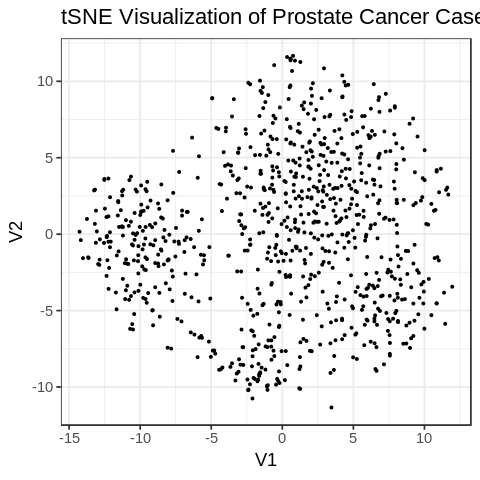

DBSCAN clustering for 863 objects.
Parameters: eps = 1.5, minPts = 15
The clustering contains 3 cluster(s) and 106 noise points.

  0   1   2   3 
106 474 116 167 

Available fields: cluster, eps, minPts

V1,V2,cluster,ID
-1.3959189,-4.6476141,1,PC_Pair_1
-14.2628937,0.1604518,3,PC_Pair_2
3.5794374,2.9629831,1,PC_Pair_3
5.9716910,-1.4912276,1,PC_Pair_4
6.3676282,3.5761073,1,PC_Pair_5
0.5680226,5.9295431,1,PC_Pair_6


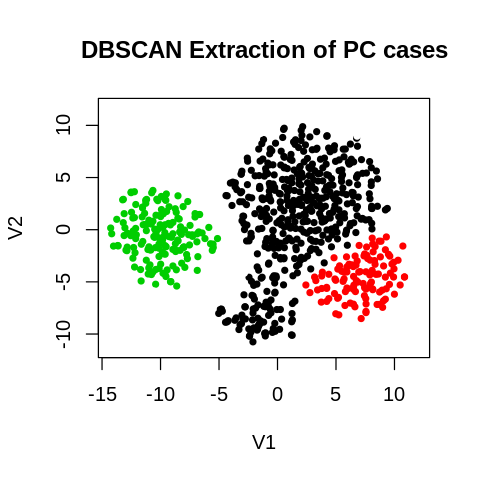

In [82]:
ess_siv_probs <- read.csv("/data/gunaseka/ESS_MCCS_Analysis/ESS_SIV_Probes.csv")
dim(ess_siv_probs)
cancer_cases <- mccs_ess[mccs_ess$CancerCellType=='PC' & mccs_ess$CaseControl==1,]
cancer_control <- mccs_ess[mccs_ess$CancerCellType=="PC" & mccs_ess$CaseControl==0,]
cancer_cases_methy<- cancer_cases[,ess_siv_probs$CG]

dim(cancer_cases_methy)
nums <- unlist(lapply(cancer_cases_methy, is.numeric))
cancer_cases_methy <- cancer_cases_methy[,nums]
cancer_cases_methy <- cancer_cases_methy[ , colSums(is.na(cancer_cases_methy)) == 0]

set.seed(9)
tsne_model_3 = Rtsne(as.matrix(cancer_cases_methy), check_duplicates=T, pca=T, perplexity=30, theta=0.5, dims=2)
d_tsne_3 = as.data.frame(tsne_model_3$Y)

ggplot(d_tsne_3, aes(x=V1, y=V2)) +
  geom_point(size=0.45) +
  guides(colour=guide_legend(override.aes=list(size=6))) +
  xlab("V1") + ylab("V2") +theme_bw()+
  ggtitle("tSNE Visualization of Prostate Cancer Cases") +
  scale_colour_brewer(palette = "Set2")
res <- dbscan::dbscan(d_tsne_3,eps = 1.5, minPts = 15)
plot(d_tsne_3, col=res$cluster, pch = 20,main="DBSCAN Extraction of PC cases")
#points(d_tsne_1[res$cluster == 0L], col = "grey", pch = "+")
res


d_tsne_3$cluster <- res$cluster
d_tsne_3$ID <- cancer_cases$ID
head(d_tsne_3) 

[1] 2189   31

[1]  863 2189

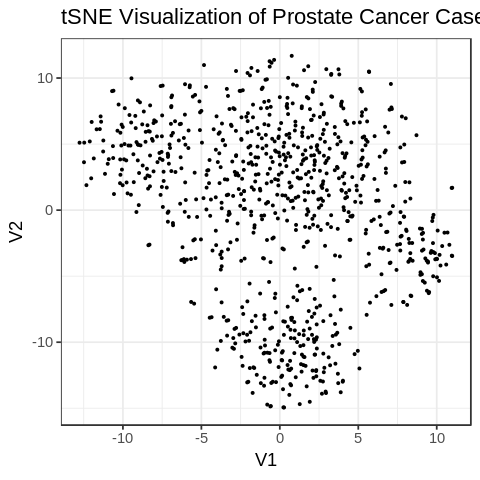

In [71]:
ess_siv_probs <- ess_siv_probs[!(ess_siv_probs$Assoc..Gene=="DUSP22" | ess_siv_probs$Assoc..Gene=="VTRNA2-1") ,]
dim(ess_siv_probs)

cancer_cases <- mccs_ess[mccs_ess$CancerCellType=='PC' & mccs_ess$CaseControl==1,]
cancer_cases_methy<- cancer_cases[,ess_siv_probs$CG]

dim(cancer_cases_methy)
nums <- unlist(lapply(cancer_cases_methy, is.numeric))
cancer_cases_methy <- cancer_cases_methy[,nums]
cancer_cases_methy <- cancer_cases_methy[ , colSums(is.na(cancer_cases_methy)) == 0]

set.seed(9)
tsne_model_removed = Rtsne(as.matrix(cancer_cases_methy), check_duplicates=T, pca=T, perplexity=30, theta=0.5, dims=2)
tsne_model_removed = as.data.frame(tsne_model_removed$Y)

ggplot(tsne_model_removed, aes(x=V1, y=V2)) +
  geom_point(size=0.45) +
  guides(colour=guide_legend(override.aes=list(size=6))) +
  xlab("V1") + ylab("V2") +theme_bw()+
  ggtitle("tSNE Visualization of Prostate Cancer Cases") +
  scale_colour_brewer(palette = "Set2")

DBSCAN clustering for 863 objects.
Parameters: eps = 1.4, minPts = 15
The clustering contains 4 cluster(s) and 177 noise points.

  0   1   2   3   4 
177 348 108 152  78 

Available fields: cluster, eps, minPts

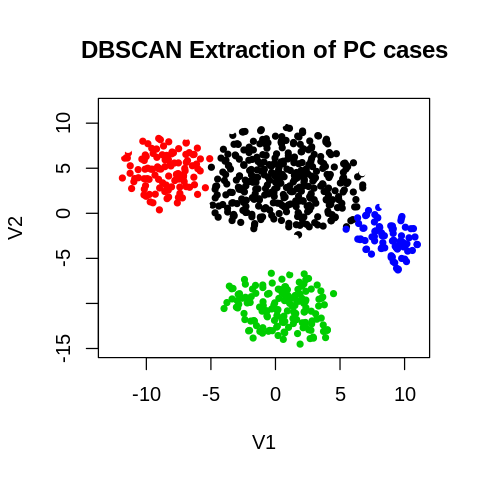

In [79]:
res_removed <- dbscan::dbscan(tsne_model_removed,eps = 1.4, minPts = 15)
plot(tsne_model_removed, col=res_removed$cluster, pch = 20,main="DBSCAN Extraction of PC cases")
#points(d_tsne_1[res$cluster == 0L], col = "grey", pch = "+")
res_removed


In [80]:
tsne_model_removed$cluster <- res_removed$cluster
tsne_model_removed$ID <- cancer_cases$ID
head(tsne_model_removed)

V1,V2,cluster,ID
7.0578659,-0.1809781,4,PC_Pair_1
1.2691464,-14.6889133,0,PC_Pair_2
5.1002495,6.6445371,0,PC_Pair_3
-2.6150420,1.5941148,1,PC_Pair_4
-1.1306926,-0.6931738,1,PC_Pair_5
0.6683236,4.0480095,1,PC_Pair_6


In [84]:
head(d_tsne_3)

V1,V2,cluster,ID
-1.3959189,-4.6476141,1,PC_Pair_1
-14.2628937,0.1604518,3,PC_Pair_2
3.5794374,2.9629831,1,PC_Pair_3
5.9716910,-1.4912276,1,PC_Pair_4
6.3676282,3.5761073,1,PC_Pair_5
0.5680226,5.9295431,1,PC_Pair_6


In [90]:
length(intersect(d_tsne_3[d_tsne_3$cluster==1,]$ID,tsne_model_removed[tsne_model_removed$cluster==1,]$ID))
length(intersect(d_tsne_3[d_tsne_3$cluster==1,]$ID,tsne_model_removed[tsne_model_removed$cluster==2,]$ID))
length(intersect(d_tsne_3[d_tsne_3$cluster==1,]$ID,tsne_model_removed[tsne_model_removed$cluster==3,]$ID))

[1] 334

[1] 2

[1] 0

In [91]:
length(intersect(d_tsne_3[d_tsne_3$cluster==2,]$ID,tsne_model_removed[tsne_model_removed$cluster==1,]$ID))
length(intersect(d_tsne_3[d_tsne_3$cluster==2,]$ID,tsne_model_removed[tsne_model_removed$cluster==2,]$ID))
length(intersect(d_tsne_3[d_tsne_3$cluster==2,]$ID,tsne_model_removed[tsne_model_removed$cluster==3,]$ID))

[1] 0

[1] 104

[1] 0

In [92]:
length(intersect(d_tsne_3[d_tsne_3$cluster==3,]$ID,tsne_model_removed[tsne_model_removed$cluster==1,]$ID))
length(intersect(d_tsne_3[d_tsne_3$cluster==3,]$ID,tsne_model_removed[tsne_model_removed$cluster==2,]$ID))
length(intersect(d_tsne_3[d_tsne_3$cluster==3,]$ID,tsne_model_removed[tsne_model_removed$cluster==3,]$ID))

[1] 0

[1] 0

[1] 148